In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install utils

In [ ]:
!pip show utils

Name: utils
Version: 1.0.2
Summary: A grab-bag of utility functions and objects
Home-page: http://github.com/haaksmash/pyutils
Author: Haak Saxberg
Author-email: haak.erling@gmail.com
License: 
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


In [ ]:
!pwd

/content


In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot.inputs.tf_keras import PlotLossesCallback

**Importing** **Libraries**

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
from IPython.display import SVG, Image
from livelossplot.inputs.tf_keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install utils

**Getting total number of images of each** **category**

In [ ]:
for expression in os.listdir("/content/drive/MyDrive/FER DATASET/train/train"):
  print(str(len(os.listdir("/content/drive/MyDrive/FER DATASET/train/train/" + expression))) + " " + expression + " images")

2325 surprise images
1547 angry images
1077 happy images
2511 sad images
484 fear images
2543 neutral images
436 disgust images


In [ ]:
img_size = 48
batch_size = 128
datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("/content/drive/MyDrive/FER DATASET/train",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/content/drive/MyDrive/FER DATASET/test",
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 10923 images belonging to 1 classes.
Found 7240 images belonging to 1 classes.


In [ ]:
# Initialising the CNN
model = Sequential()
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
# 2nd Convolution layer
#model.add(Conv2D(128,(5,5), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
# 3rd Convolution layer
#model.add(Conv2D(512,(3,3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
# 4th Convolution layer
#model.add(Conv2D(512,(3,3), padding='same'))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
# Flattening
model.add(Flatten())
# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(7, activation='softmax'))
opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_7 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 36864)            

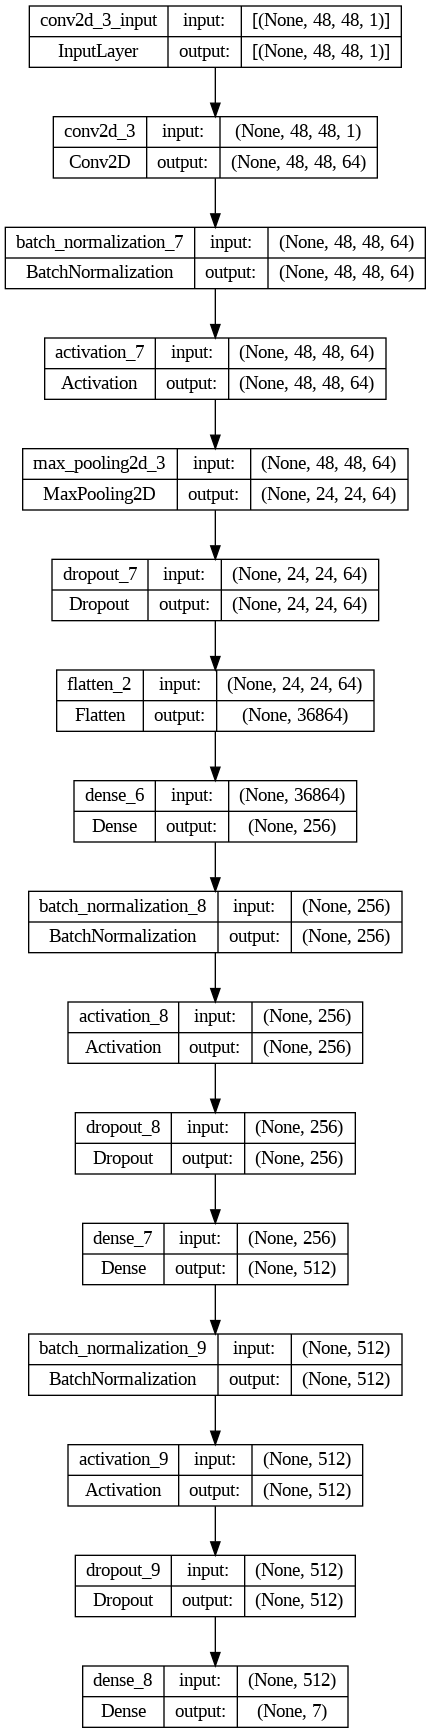

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
Image('model.png',width=400, height=200)

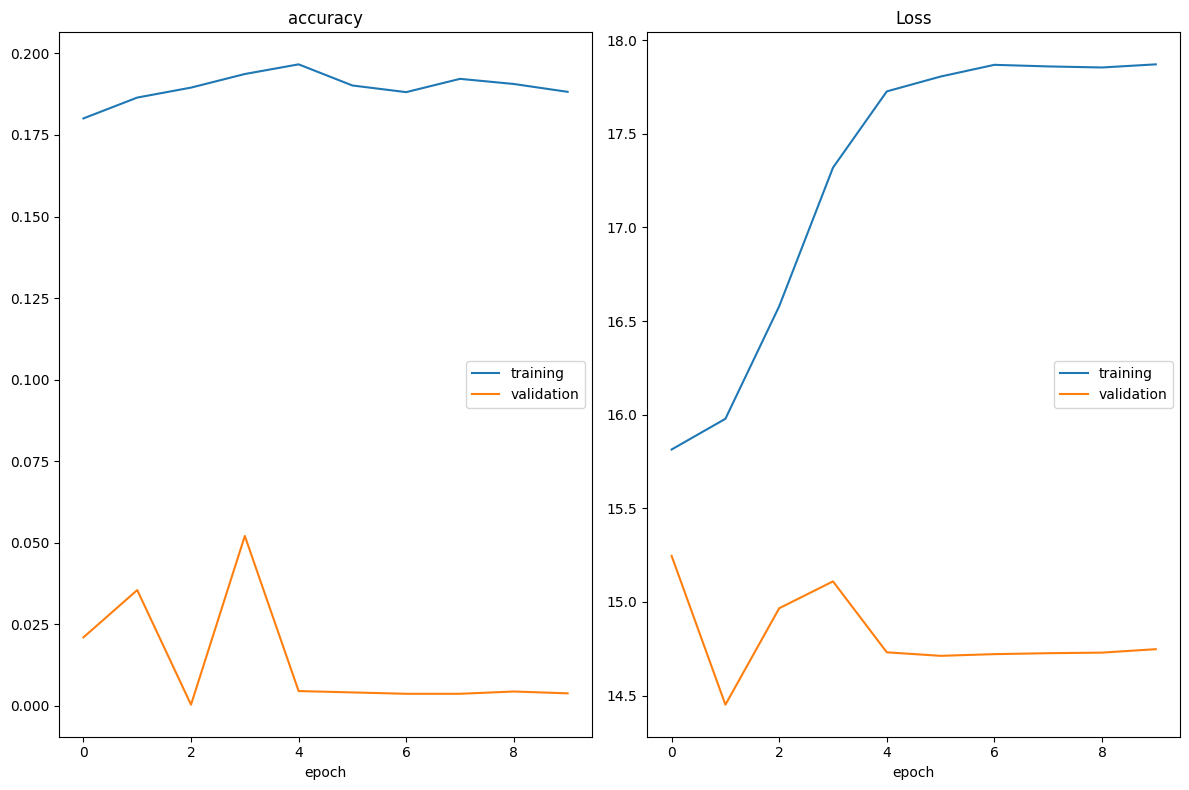

accuracy
	training         	 (min:    0.180, max:    0.197, cur:    0.188)
	validation       	 (min:    0.000, max:    0.052, cur:    0.004)
Loss
	training         	 (min:   15.814, max:   17.871, cur:   17.871)
	validation       	 (min:   14.451, max:   15.246, cur:   14.748)

Epoch 10: saving model to model_weights.h5
85/85 [==============================] - 155s 2s/step - loss: 17.8710 - accuracy: 0.1882 - val_loss: 14.7480 - val_accuracy: 0.0038 - lr: 1.0000e-05
CPU times: user 21min 53s, sys: 7min 51s, total: 29min 45s
Wall time: 1h 26min 16s


In [30]:
%%time
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

**Represent Model as JSON String**

In [31]:
model_json = model.to_json()
model.save_weights('model_weights.h5')
with open("model.json", "w") as json_file:
    json_file.write(model_json)

**Class for loading model and weights**

In [32]:
from tensorflow.keras.models import model_from_json
class FacialExpressionModel(object):
    EMOTIONS_LIST = ["Angry", "Disgust",
                    "Fear", "Happy",
                    "Neutral", "Sad",
                    "Surprise"]
    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)
        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model.make_predict_function()
    def predict_emotion(self, img):
        self.preds = self.loaded_model.predict(img)
        return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]

**Getting frames and doing prediction**




In [33]:
import cv2
facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "model_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX
class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)
    def __del__(self):
        self.video.release()
    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)
        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]
            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])
            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)
        return fr

**Function for showing output video**

In [34]:
def gen(camera):
    while True:
        frame = camera.get_frame()
        cv2.imshow('/content/drive/MyDrive/Facial-Expression-Recognization (1).gif',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

**Running the code**

In [35]:
gen(VideoCamera())

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
